# Handwritten Digit Classfication using Convolution LSTM

In this example, we are going to use the MNIST dataset to train a simple convolution LSTM model. MNIST is a simple computer vision dataset of handwritten digits. It has 60,000 training examles and 10,000 test examples. "It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting." For more details, please checkout the website [MNIST](http://yann.lecun.com/exdb/mnist/).

In [1]:
%pylab inline

import pandas
import datetime as dt

from bigdl.nn.layer import *
from bigdl.nn.criterion import *
from bigdl.optim.optimizer import *
from bigdl.util.common import *
from bigdl.dataset.transformer import *
from bigdl.dataset import mnist

init_engine()

Populating the interactive namespace from numpy and matplotlib


## Load MNIST dataset

Please edit the "mnist_path" accordingly. If the "mnist_path" directory does not consist of the mnist data, `mnist.read_data_sets` method will download the dataset directly to the directory.

In [2]:
# Get and store MNIST into RDD of Sample, please edit the "mnist_path" accordingly.
mnist_path = "datasets/mnist"
def get_mnist(sc, seq_len, data_type="train", location="/tmp/mnist"):
    TRAIN_MEAN = 0.13066047740239506 * 255
    TRAIN_STD = 0.3081078 * 255
    (images, labels) = mnist.read_data_sets(location, data_type)
    dim = images.shape[0]
    features = np.resize(images[0:dim - 100, ...], (dim/seq_len, seq_len, 1, 28, 28))
    labels = np.resize(images[1:dim - 99, ...], (dim/seq_len, seq_len, 1, 28, 28))

    features_rdd = sc.parallelize(features)
    labels_rdd = sc.parallelize(labels)

    record = features_rdd.zip(labels_rdd).map(lambda features_label:
                                    Sample.from_ndarray((features_label[0]-TRAIN_MEAN)/TRAIN_STD, (features_label[1]-TRAIN_MEAN)/TRAIN_STD))
    return record

## Convolution LSTM Network Setup

This time we will use a convolution network to predict next images in a sequence. You can checkout this [paper](https://arxiv.org/abs/1506.04214) to get a detailed understanding of conv LSTMs in particular.

In [3]:
# Parameters
output_size = 45
input_size = 1
seq_len = 4
batch_size = 4

train_data = get_mnist(sc, seq_len, "train", mnist_path)
test_data = get_mnist(sc, seq_len, "test", mnist_path)
print train_data.count()
print test_data.count()

('Extracting', 'datasets/mnist/train-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/train-labels-idx1-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-images-idx3-ubyte.gz')
('Extracting', 'datasets/mnist/t10k-labels-idx1-ubyte.gz')
15000
2500


In [4]:
def build_model(input_size, output_size):
    model = Sequential()

    encoder = Sequential()
    encoder.add(TimeDistributed(SpatialConvolution(input_size, 32, 7, 7, 1, 1, 3, 3)))
    encoder.add(TimeDistributed(Tanh()))
    model.add(encoder)

    model.add(Recurrent()
              .add(ConvLSTMPeephole(32, output_size, 7, 7, 1, with_peephole=True)))

    decoder = Sequential()
    decoder.add(TimeDistributed(SpatialConvolution(output_size, 1, 7, 7, 1, 1, 3, 3)))
    model.add(decoder)

    model.add(Sigmoid())
    return model

convlstm_model = build_model(input_size, output_size)

creating: createSequential
creating: createSequential
creating: createSpatialConvolution
creating: createTimeDistributed
creating: createTanh
creating: createTimeDistributed
creating: createRecurrent
creating: createConvLSTMPeephole
creating: createSequential
creating: createSpatialConvolution
creating: createTimeDistributed
creating: createSigmoid


## Optimizer Setup

In [5]:
# Create an Optimizer

optimizer = Optimizer(
            model=convlstm_model,
            training_rdd=train_data,
            criterion=TimeDistributedCriterion(MSECriterion(), size_average=True),
            optim_method=SGD(learningrate=1e-3, learningrate_decay=1e-5),
            end_trigger=MaxIteration(2000),
            batch_size=batch_size)

# Set the validation logic
optimizer.set_validation(
    batch_size=batch_size,
    val_rdd=test_data,
    trigger=SeveralIteration(200),
    val_method=[Loss(TimeDistributedCriterion(MSECriterion(), size_average=True))]
)

app_name='convlstm-'+dt.datetime.now().strftime("%Y%m%d-%H%M%S")
train_summary = TrainSummary(log_dir='/tmp/bigdl_summaries',
                                     app_name=app_name)
train_summary.set_summary_trigger("Parameters", SeveralIteration(200))
val_summary = ValidationSummary(log_dir='/tmp/bigdl_summaries',
                                        app_name=app_name)
optimizer.set_train_summary(train_summary)
optimizer.set_val_summary(val_summary)
print "saving logs to ",app_name

creating: createMSECriterion
creating: createTimeDistributedCriterion
creating: createDefault
creating: createSGD
creating: createMaxIteration
creating: createOptimizer
creating: createSeveralIteration
creating: createMSECriterion
creating: createTimeDistributedCriterion
creating: createLoss
creating: createTrainSummary
creating: createSeveralIteration
creating: createValidationSummary
saving logs to  convlstm-20170716-162006


In [6]:
%%time
# Boot training process
trained_model = optimizer.optimize()
print "Optimization Done."

Optimization Done.
CPU times: user 169 ms, sys: 36.4 ms, total: 205 ms
Wall time: 32min 12s


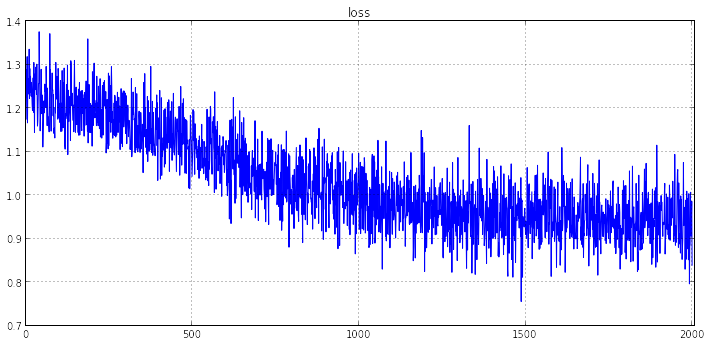

In [7]:
loss = np.array(train_summary.read_scalar("Loss"))

plt.figure(figsize = (12,12))
plt.subplot(2,1,1)
plt.plot(loss[:,0],loss[:,1],label='loss')
plt.xlim(0,loss.shape[0]+10)
plt.grid(True)
plt.title("loss")